# Notebook to format data from ""Super machine learning: Improving accuracy and reducing variance of behaviour classification from accelerometry"", Ladds et al (2017).

Paper can be found [here](https://www.researchgate.net/publication/315746012_Super_machine_learning_Improving_accuracy_and_reducing_variance_of_behaviour_classification_from_accelerometry).

[Data](https://github.com/MoniqueLadds/behaviour_accelerometry)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
from sklearn.decomposition import PCA
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/ladds_seals/raw_data'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/ladds_seals'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fps = glob.glob(raw_data_dir + '/*/*.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Set up metadata, individuals

# Dataset metadata
dataset_metadata = {}
sr = 25
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'ladds_seals'

individuals = []
for fp in data_fps:
    individual = fp.split('/')[-2]
    individuals.append(individual)
    
# make a list of individuals
individuals = list(set(individuals))
individuals.sort()

In [6]:
# Set up data splits by individual

test_proportion = .25
val_proportion = .2
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(1280)
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

['abbey', 'bella', 'groucho', 'malie', 'mav', 'maxine', 'rocky']
['nelson', 'teiko']
['abbey', 'bella', 'groucho', 'malie', 'mav', 'maxine', 'nelson', 'rocky', 'teiko']
['miri', 'ronnie', 'sly']


In [7]:
# Set up clip ids

# Clip ids
clip_ids = []
test_clip_ids = []
train_clip_ids = []
dev_clip_ids = []
val_clip_ids = []
for fp in data_fps:
    individual = fp.split('/')[-2]
    fn = fp.split('/')[-1]
    clip_id = individual + '-' + fn.split('.')[0]
    clip_ids.append(clip_id)
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [8]:
## Integer codes for individuals

individual_to_individual_id = {individual : i for i, individual in enumerate(individuals)}

clip_id_to_individual_id = {clip_id : individual_to_individual_id[clip_id.split('-')[0]] for clip_id in clip_ids}

dataset_metadata['individual_ids'] = [i for i, individual in enumerate(individuals)] # 
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [9]:
## Integer codes for specific behaviors

# list of behaviors (from Jeantet et al 2020)
beh_names = ['unknown', 
             'travelling',
             'resting',
             'grooming',
             'feeding'
            ]

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

# extract directly from the annotations
fp = data_fps[0]
all_annotations = pd.read_csv(fp)

for fp in data_fps[1:]:
    all_annotations = all_annotations.append(pd.read_csv(fp))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
# What are the observed labels?

all_annotations['type'].value_counts()

Travelling    502640
Foraging      303698
Other         213424
Resting       179637
Grooming       59021
Name: type, dtype: int64

In [11]:
# Map to beh_labels following labels in published article (4 label scheme)

observed_labels_to_beh_label = {'Travelling' : 'travelling',
                                'Foraging' : 'feeding',
                                'Other' : 'unknown',
                                'Resting' : 'resting',
                                'Grooming' : 'grooming'
                               }

In [12]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'Depth', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [13]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [14]:
# Standard practice is to remove gravitational bias from each accel channel by applying a boxcar filter, then subtract the result

def smooth(series, smoothing_cutoff_freq):
    # smooth
    sos = signal.butter(10, smoothing_cutoff_freq, 'low', fs = sr, output = 'sos')
    series = signal.sosfilt(sos, series)
    return series

def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

# Convenience function to detect nans.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

#Interpolates all nan values of given array
def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

In [15]:
# For each clip, create and save the data in the correct format

for clip_id in clip_ids:
    # load features
    data_fp = os.path.join(raw_data_dir, clip_id.split('-')[0], '-'.join(clip_id.split('-')[1:]) + '.csv')
    
    clip_df = pd.read_csv(data_fp)
    
    clip_dur_samples = len(clip_df)
    
    # Correct for gravitational bias and remove nans
    per_frame_AccX = np.array(clip_df['x'])
    per_frame_AccX = interpolate_nan(per_frame_AccX)
    #per_frame_AccX = smooth(per_frame_AccX, 20.)
    per_frame_StaticAccX, per_frame_AccX = extract_static(per_frame_AccX, 0.3) 
    
    per_frame_AccY = np.array(clip_df['y'])
    per_frame_AccY = interpolate_nan(per_frame_AccY)
    #per_frame_AccY = smooth(per_frame_AccY, 20.)
    per_frame_StaticAccY, per_frame_AccY = extract_static(per_frame_AccY, 0.3) 
    
    per_frame_AccZ = np.array(clip_df['z'])
    per_frame_AccZ = interpolate_nan(per_frame_AccZ)
    #per_frame_AccZ = smooth(per_frame_AccZ, 20.)
    per_frame_StaticAccZ, per_frame_AccZ = extract_static(per_frame_AccZ, 0.3) 
    
    per_frame_Depth = np.array(clip_df['depth'])
    per_frame_Depth = interpolate_nan(per_frame_Depth) ## there is a short period of nans in one depth track
    per_frame_Depth = np.gradient(per_frame_Depth)
    
    # reformat
    per_frame_AccX = np.expand_dims(per_frame_AccX, axis = -1)
    per_frame_AccY = np.expand_dims(per_frame_AccY, axis = -1)
    per_frame_AccZ = np.expand_dims(per_frame_AccZ, axis = -1)
    per_frame_StaticAccX = np.expand_dims(per_frame_StaticAccX, axis = -1)
    per_frame_StaticAccY = np.expand_dims(per_frame_StaticAccY, axis = -1)
    per_frame_StaticAccZ = np.expand_dims(per_frame_StaticAccZ, axis = -1)
    per_frame_Depth = np.expand_dims(per_frame_Depth, axis = -1)
    
    per_frame_annotations = np.expand_dims(np.array(clip_df['type'].map(lambda x: beh_str_to_int[observed_labels_to_beh_label[x]])), axis = -1)
    
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    clip_data = np.concatenate([per_frame_AccX,
                                per_frame_AccY, 
                                per_frame_AccZ,
                                per_frame_StaticAccX,
                                per_frame_StaticAccY, 
                                per_frame_StaticAccZ, 
                                per_frame_Depth, 
                                per_frame_individual_id, 
                                per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
    np.save(clip_data_fp, clip_data)

## Check it all looks ok

In [16]:
clip_id = clip_ids[4]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)

In [17]:
np.shape(data)

(15736, 9)

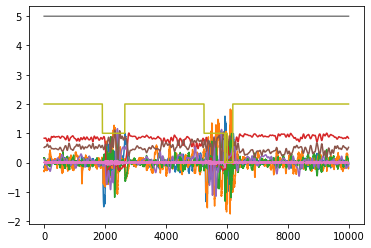

In [18]:
for i in range(np.shape(data)[1]):
    plt.plot(data[1000:11000, i])

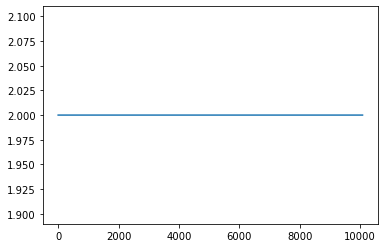

In [21]:
plt.plot(data[:, 7])

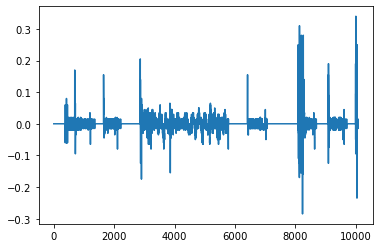

In [20]:
clip_id = clip_ids[13]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)
plt.plot(data[:, 6])